# Tutorial 9b: Segmentation

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](t9b_segmentation.ipynb).*

In [1]:
import warnings

# Workhorse
import numpy as np

# A whole bunch of skimage stuff
import skimage.feature
import skimage.filter
import skimage.filter.rank
import skimage.io
import skimage.morphology
import skimage.restoration
import skimage.segmentation
import skimage.transform

# And some useful scipy.ndimage stuff
import scipy.ndimage

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/Justin/anaconda/lib/python3.4/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In this tutorial, we will use the more convenient RFP channel to segment our images.  At the end of this tutorial, you will be able to use the segmented RFP channel to subsequently analyze the YFP and CFP channels to acquire data about the $\sigma$ factors, which you will do in your homework.

## The data set

We already discussed the data set in [Tutorial 9a](t9a_basic_filtering_and_thresholding.html).  We will proceed with segmenting the RFP images and acquiring data in this tutorial.

### Let's have a look

First, let's look at the RFP channel more closely.

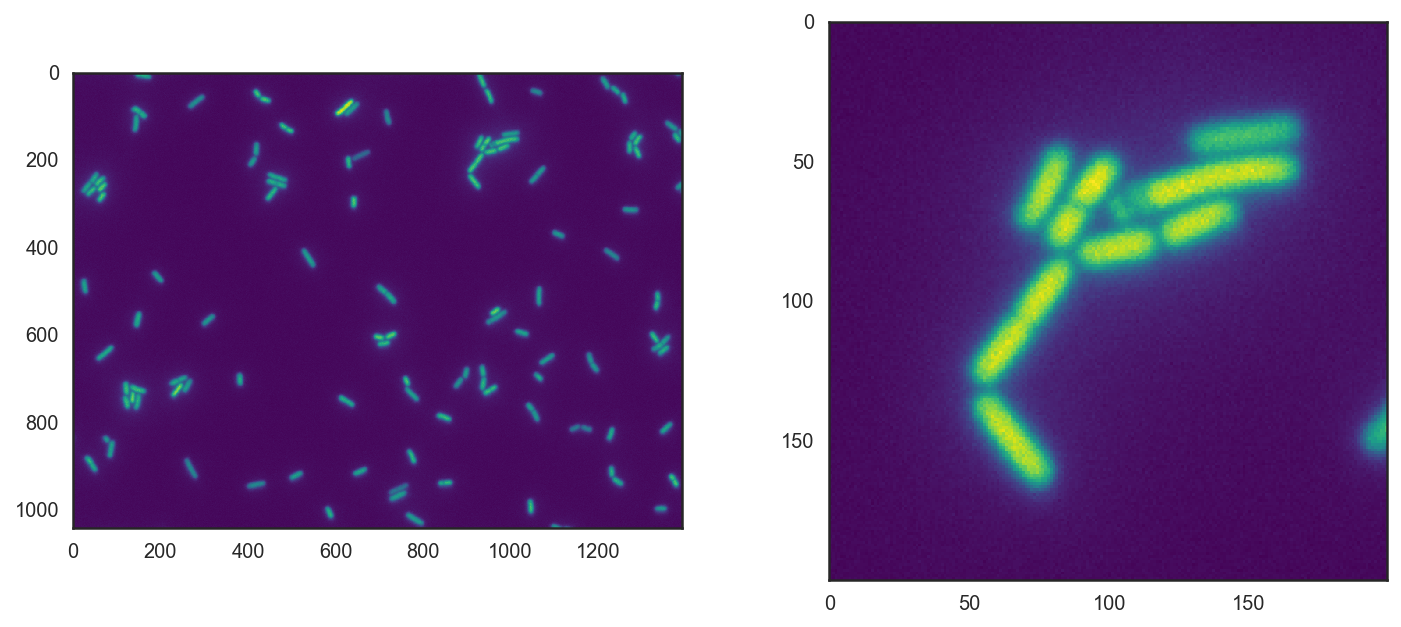

In [2]:
# Define directory containing files
im_file = '../data/park_et_al/snaps001-001-r.tif'

# So we have it, the interpixel distance
physical_size = 0.065  # microns

# Get image file
im = skimage.io.imread(im_file)

# Display the image, including another nice zoom region
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].imshow(im, cmap=plt.cm.viridis)
    ax[1].imshow(im[100:300, 850:1050], cmap=plt.cm.viridis)

We see cleaner separation between cells than before.  There is also substantially less noise than in phase.  Let's try thresholding using the method we devised last time.

## Thresholding the RFP image

We will reuse our thresholding function from [Tutorial 9a](t9a_basic_filtering_and_thresholding.html).

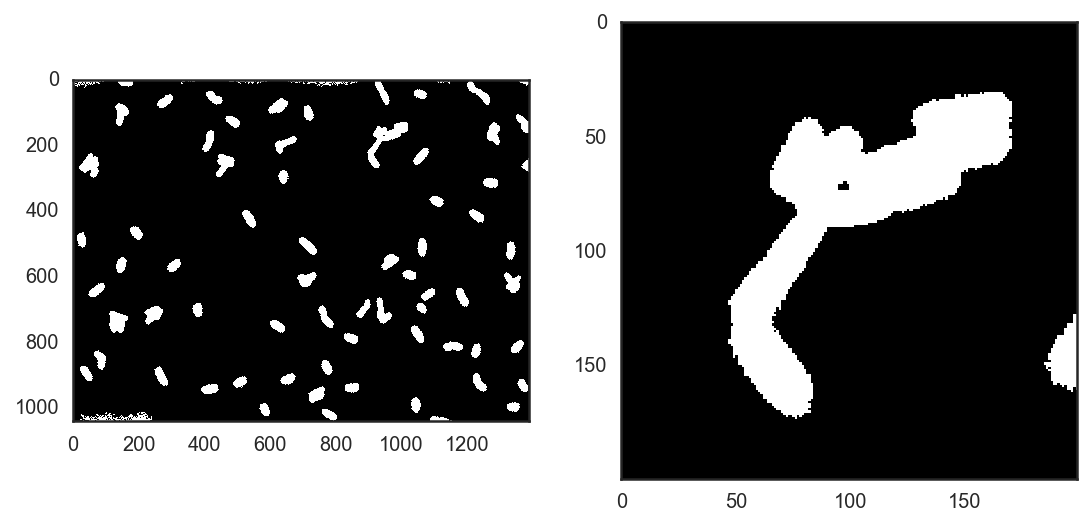

In [4]:
def bebi103_thresh(im, selem, white_true=True, k_range=(0.5, 1.5), 
                   min_size=100):
    """
    Threshold image as described above.  Morphological mean filter is 
    applied using selem.
    """
    
    # Determine comparison operator
    if white_true:
        compare = np.greater
        sign = -1
    else:
        compare = np.less
        sign = 1
    
    # Do the mean filter
    im_mean = skimage.filter.rank.mean(im, selem)

    # Compute number of pixels in binary image as a function of k
    k = np.linspace(k_range[0], k_range[1], 100)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = compare(im, k[i] * im_mean).sum() 

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))

    # Find index of maximal second derivative
    max_ind = np.argmax(sign * dn_pix_dk2)

    # Use this index to set k
    k_opt = k[max_ind - sign * 2]

    # Threshold with this k
    im_bw = compare(im, k_opt * im_mean)

    # Remove all the small objects
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=min_size)
   
    return im_bw, k_opt

# Make the structuring element 50 pixel radius disk
selem = skimage.morphology.disk(50)

# Threshhold based on mean filter
im_bw, k = bebi103_thresh(im, selem, white_true=True, min_size=400)

# Show image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_bw, cmap=plt.cm.gray)
    ax[1].imshow(im_bw[100:300, 850:1050], cmap=plt.cm.gray);

That worked all right, but we do see some issues at the boundaries.  We can clean this up using `skimage.segmentation.clear_border`.

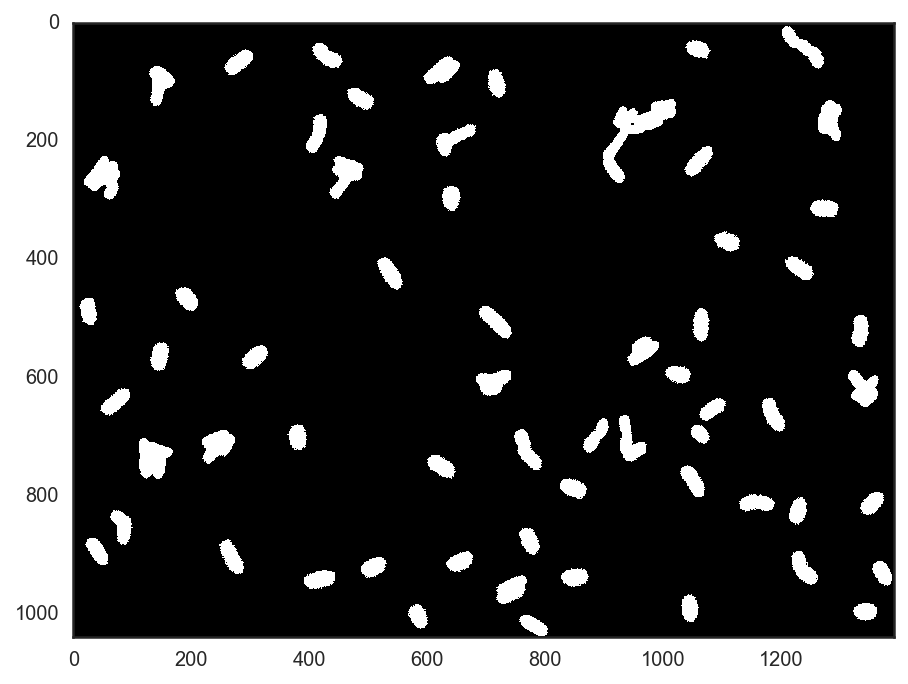

In [5]:
# Clear the border
im_bw = skimage.segmentation.clear_border(im_bw)

# Show image
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

This is fine and good, but there is the problem that bacteria that are next to each other are connected.  We can sometimes separate these with opening, but we would like to have a better method.

## Segmentation by edge detection

While we were effective at separating bacteria from background, we were not as good at separating bacteria from each other.  Let's look closely at the bacterial image again and see if we can come up with a better method for segmentation.

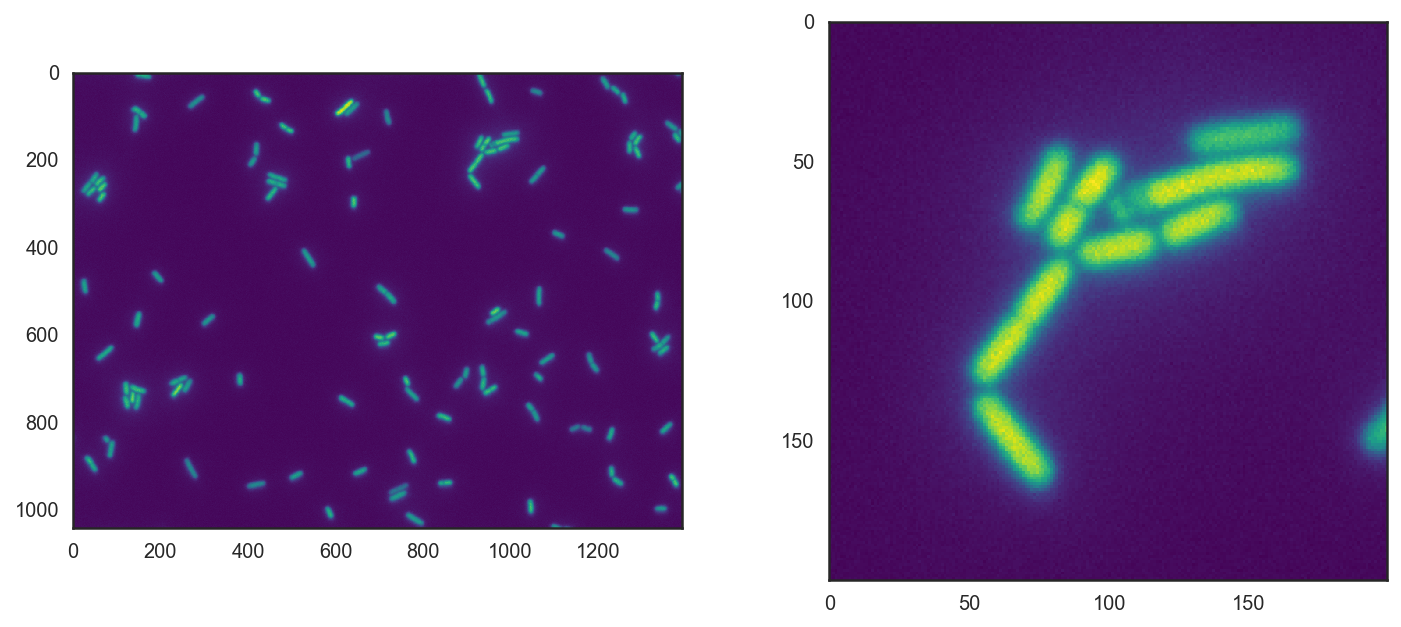

In [7]:
# Display the image, including another nice zoom region
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].imshow(im, cmap=plt.cm.viridis)
    ax[1].imshow(im[100:300, 850:1050], cmap=plt.cm.viridis)

### Sobel filtering

In the false colored image, we notice a whilte halo around the bacteria.  This means that the pixel values go from red toward blue around the borders of the bacteria.  Therefore, if we can find there the magnitude of the *gradient* of pixel values is high, we can get the outline of the bacteria.  This procedure is called [**edge detection**](http://en.wikipedia.org/wiki/Edge_detection).  A simple way to compute the gradient is to apply a [**Sobel filter**](http://en.wikipedia.org/wiki/Sobel_operator), which approximates the gradient in pixel intensities at each point.

Going forward, we will use float images, since the edge detection algorithms do operations that result in floats.  When we use the floats, we will maximally stretch the pixel values from 0 to 1 so that we have concrete numbers for comparing gradients.  This means we make the float image by hand, not by using `skimage.img_as_float`.

Prior to attempting edge detection, we could denoise the images with a total variation filter or a Gaussian blur, but we will go forward without that step.

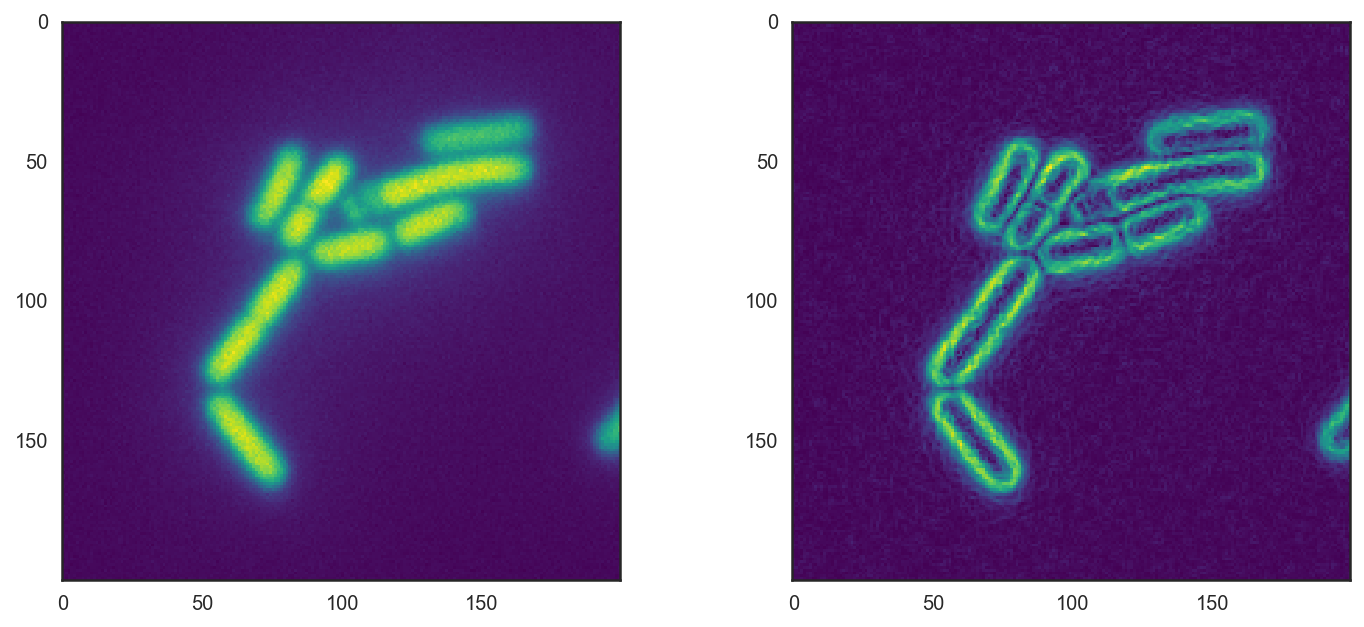

In [8]:
# Convert image to float
im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

# Apply the Sobel filter to find the gradient
im_grad = skimage.filters.sobel(im_float)

# Look at gradient image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(im_float[100:300, 850:1050], cmap=plt.cm.viridis)
    ax[1].imshow(im_grad[100:300, 850:1050], cmap=plt.cm.viridis)

### Canny edge detection

The Sobel filter did give us gradient information, but we have to figure out how to process it.  Fortunately, there is an automatic way of doing that, called [**Canny edge detection**](http://en.wikipedia.org/wiki/Canny_edge_detector).  The Canny edge detector does a series of operations, including computing the Sobel filter, to then return a binary image what is `True` where there is an edge.  (The steps of the Canny edge detector are [well-documented](http://scikit-image.org/docs/dev/api/skimage.feature.html#canny) in `skimage`.)  Prior to computing gradients, the Canny edge detector does a Gaussian blur because the subsequent steps are susceptible to noise.  We therefore need to specify the $\sigma$ value for the Gaussian blur when calling `skimage.feature.canny`.

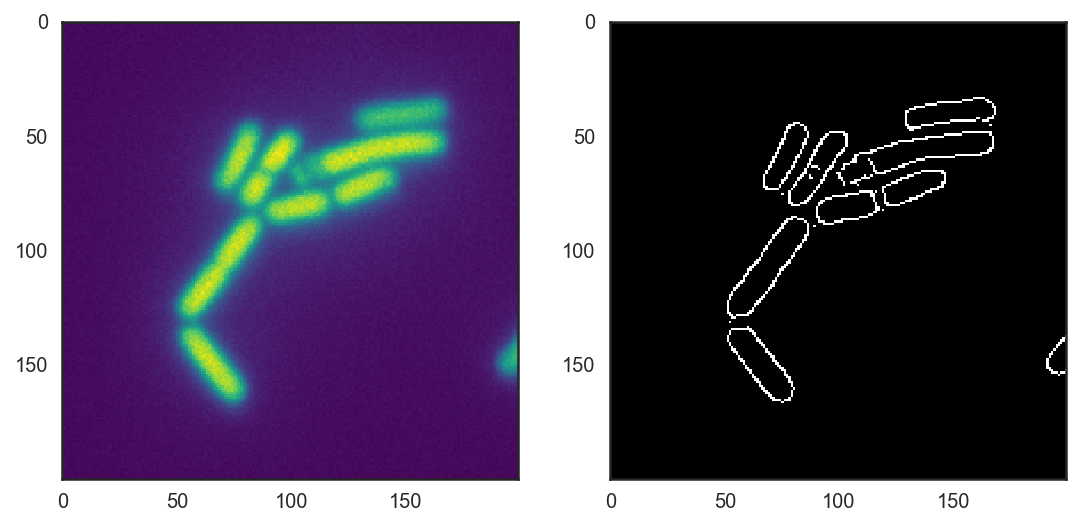

In [9]:
# Do Canny edge detection on image, use sigma = 1.4
im_edge = skimage.feature.canny(im_float, 1.4)

# Show the result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float[100:300, 850:1050], cmap=plt.cm.viridis)
    ax[1].imshow(im_edge[100:300, 850:1050], cmap=plt.cm.gray)

Much better!  The bacteria are well separated.  In order to finish the segmentation, we just need to fill them in.  There is a convenient function in `scipy.ndimage` for this.

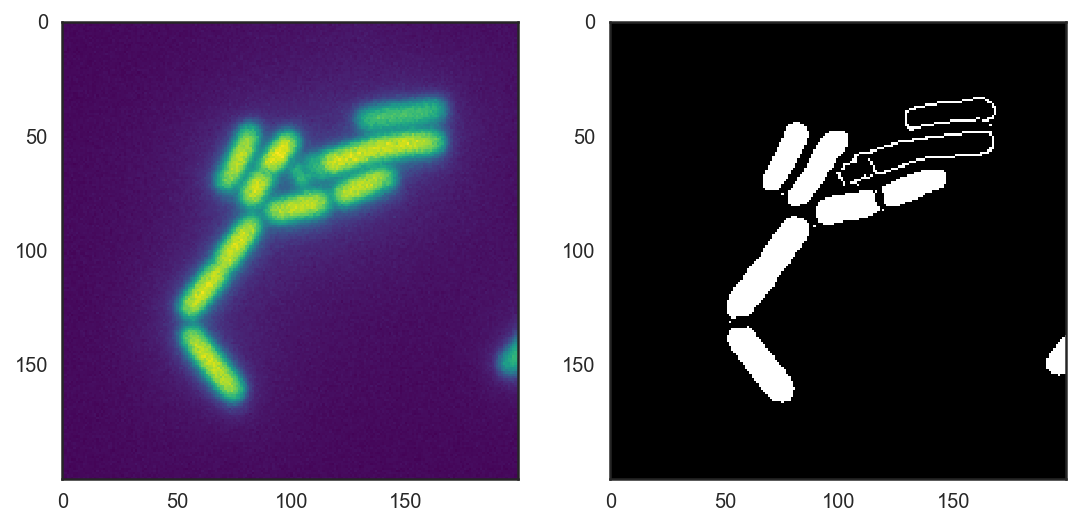

In [11]:
# Fill the holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Look at result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float[100:300, 850:1050], cmap=plt.cm.viridis)
    ax[1].imshow(im_bw[100:300, 850:1050], cmap=plt.cm.gray)

Oh no!  What happened?  If there is even a one-pixel opening in the contour of the edge, it is not closed off to the background, so that bacterium will be missed.  We can remedy this by doing a closing of the edge image.

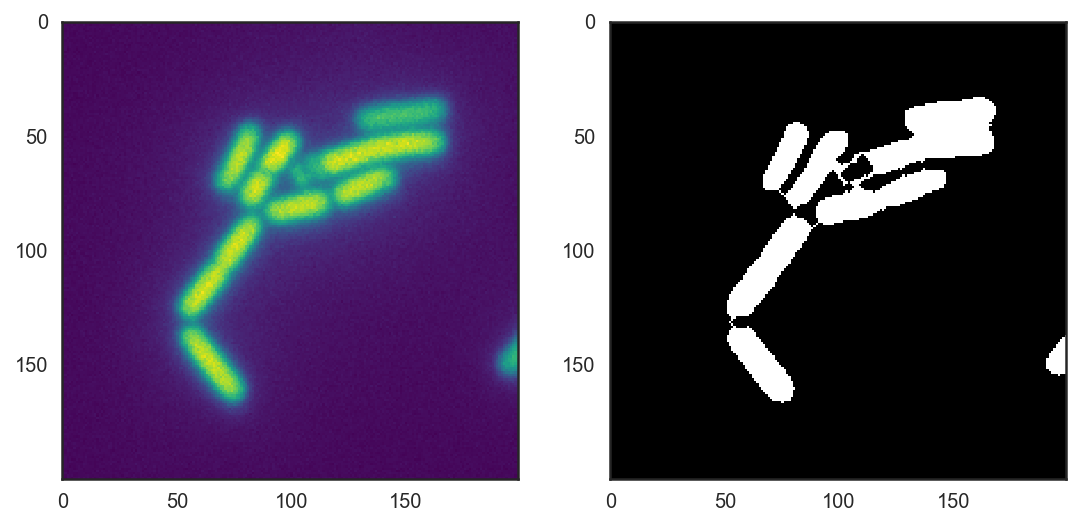

In [12]:
# Close the edge image
selem = skimage.morphology.disk(2)
im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

# Fill these holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)

# Check out results
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float[100:300, 850:1050], cmap=plt.cm.viridis)
    ax[1].imshow(im_bw[100:300, 850:1050], cmap=plt.cm.gray)

This is good, but we have the problem that we just joined cells back together again.  So, we would like another way to do edge detection that guarantees closed curves.

### Laplacian of Gaussian and zero crossing

Another common method of edge detection is the [Marr-Hildreth edge detector](http://en.wikipedia.org/wiki/Marr–Hildreth_algorithm), which uses the Laplacian of Gaussian (LoG) with zero crossing detection.  This is described in section 10.2 of Gonzalez and Woods.  The idea here is that an edge features a sudden peak or valley in the gradient (first derivative) of the pixel values of the image.  A peak or a valley in the first derivative means there is a zero-crossing in the second derivative.  As we learned in the data smoothing part of the course, taking higher order derivatives of real data results in highly amplified noise.  Therefore, the Marr-Hildreth method takes the Laplacian of a Gaussian blurred image, hence the name Laplacian of Gaussian.

`skimage` does not (yet) have a LoG filter, but `scipy.ndimage` does.  We have to specify $\sigma$ for the Gaussian blur.  We will choose 2 pixels, and it is better to err on the large side.  First, we will compute the LoG of our image.

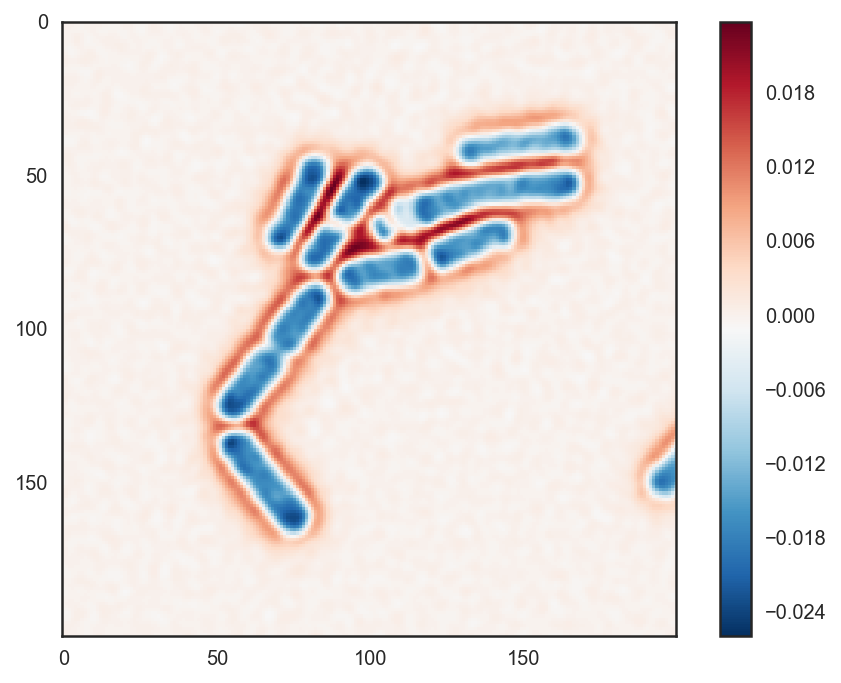

In [17]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)

# Check out results
with sns.axes_style('white'):
    plt.imshow(im_LoG[100:300, 850:1050], cmap=plt.cm.RdBu_r)
    plt.colorbar()

We use a divergent colormap (`RdBu_r`) to help us see zero crossings.  We can see zero crossings at the edges of cells.  To automatically detect them, we take a square of nine pixels.  If the center pixel has a different sign than at least one of its neighbors, there is a zero-crossing.  We can cleverly implement this by finding the maximum and minumum of each nine-pixel neighborhood and then comparing the LoG to those minima and maxima.

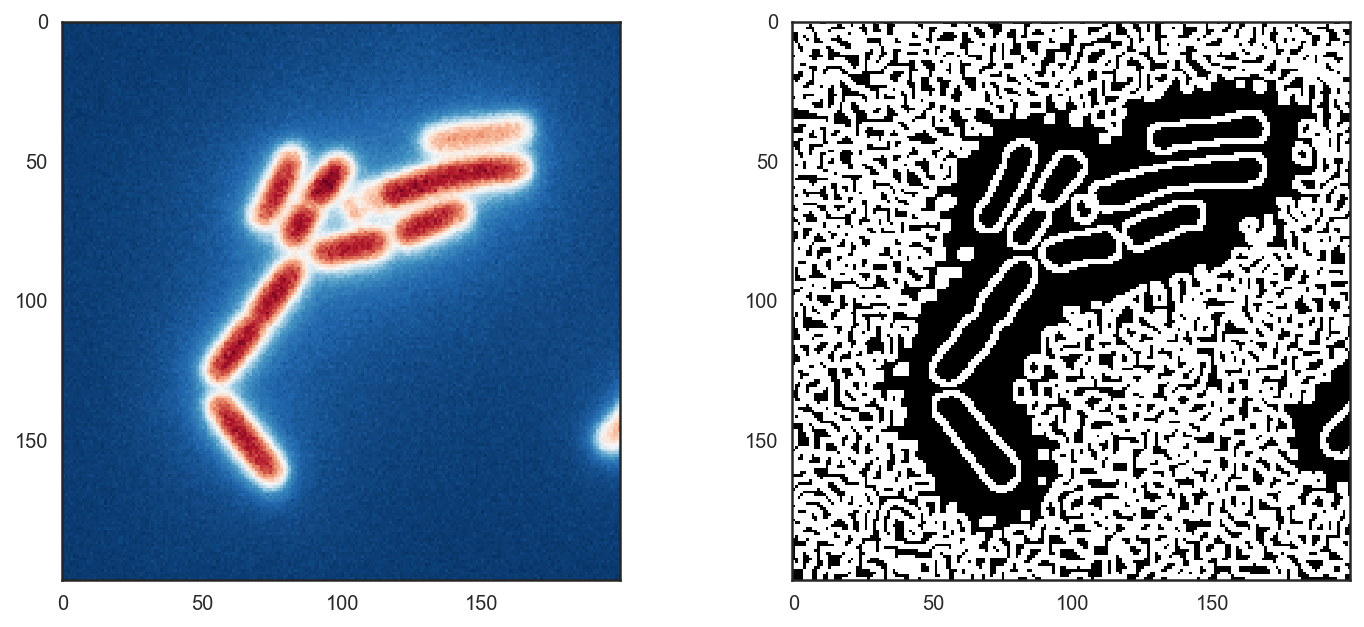

In [19]:
# 3x3 square structuring element
selem = skimage.morphology.square(3)
    
# Do max filter and min filter
im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

# Image of zero-crossings
im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))

# Show result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].imshow(im_float[100:300, 850:1050], cmap=plt.cm.RdBu_r)
    ax[1].imshow(im_edge[100:300, 850:1050], cmap=plt.cm.gray)

Yeesh!  There are lots of zero crossings in the background as well.  We can ensure that we do not get these by setting a threshold value on what the gradient must be at the zero crossings.  We can write a function to implement this.

In [20]:
def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filter.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

We'll now use this function to get our edges.

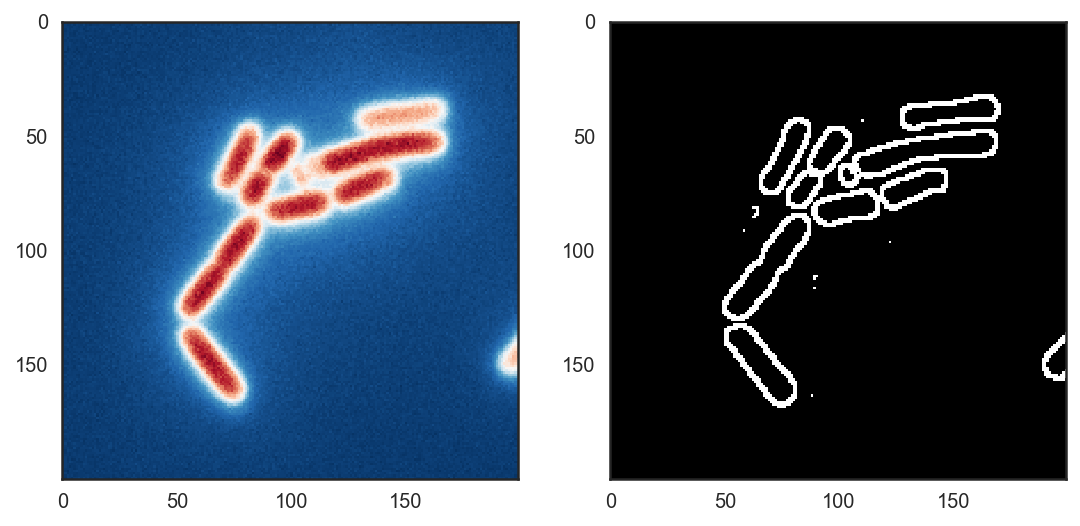

In [22]:
# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)

# Show result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float[100:300, 850:1050], cmap=plt.cm.RdBu_r)
    ax[1].imshow(im_edge[100:300, 850:1050], cmap=plt.cm.gray)

Much better!  We would like single-pixel edges, though.  We can accomplish this by [**skeletonization**](http://en.wikipedia.org/wiki/Topological_skeleton).  This technique whittles down thick lines into a single pixel without breaking them.

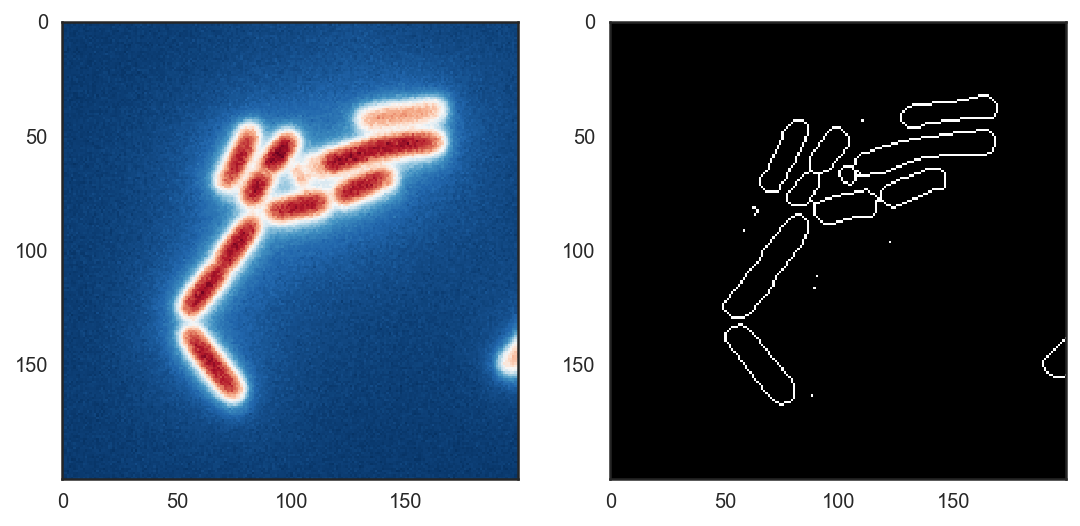

In [24]:
# Skeletonize edges
im_edge = skimage.morphology.skeletonize(im_edge)

# See result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float[100:300, 850:1050], cmap=plt.cm.RdBu_r)
    ax[1].imshow(im_edge[100:300, 850:1050], cmap=plt.cm.gray)

Finally, we can fill the holes and remove small objects to get our segmented image.

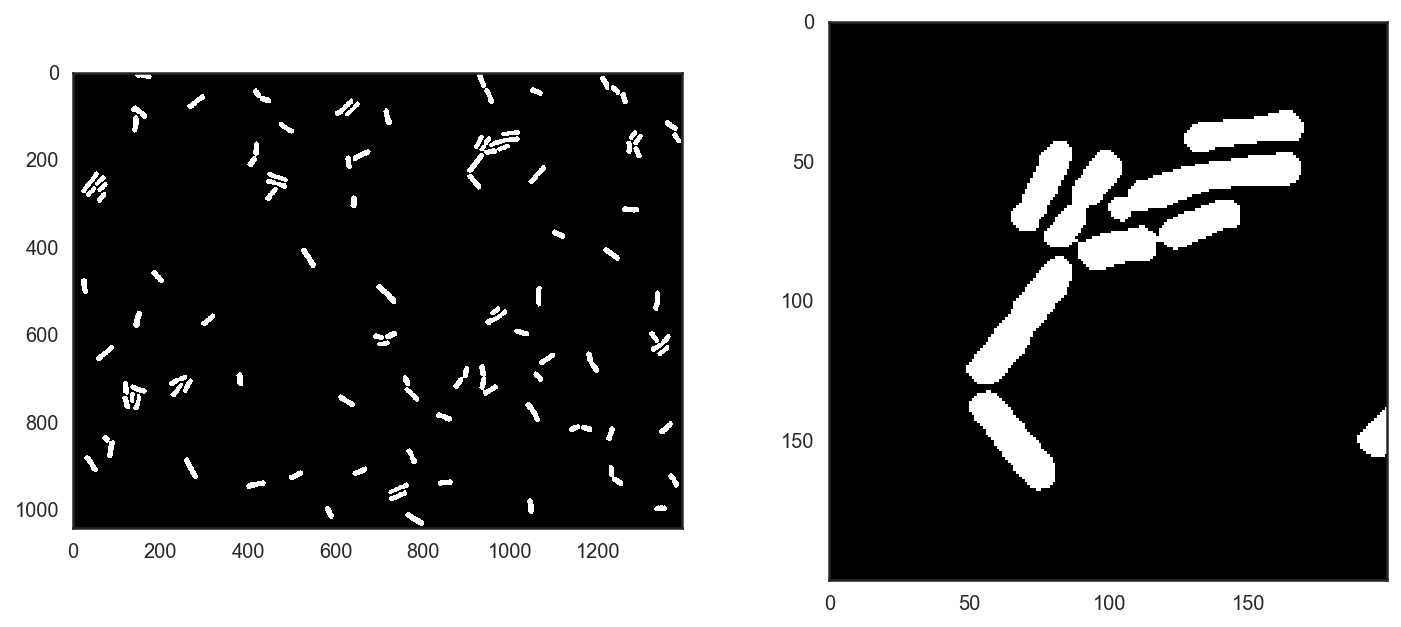

In [27]:
# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

# Show result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].imshow(im_bw, cmap=plt.cm.gray)
    ax[1].imshow(im_bw[100:300, 850:1050], cmap=plt.cm.gray)

We should actually take one more step, though.  If we are going to get quantitative information from the images, we need to make sure we only consider complete bacteria, and not those cropped by the border.  We therefore clear the border.

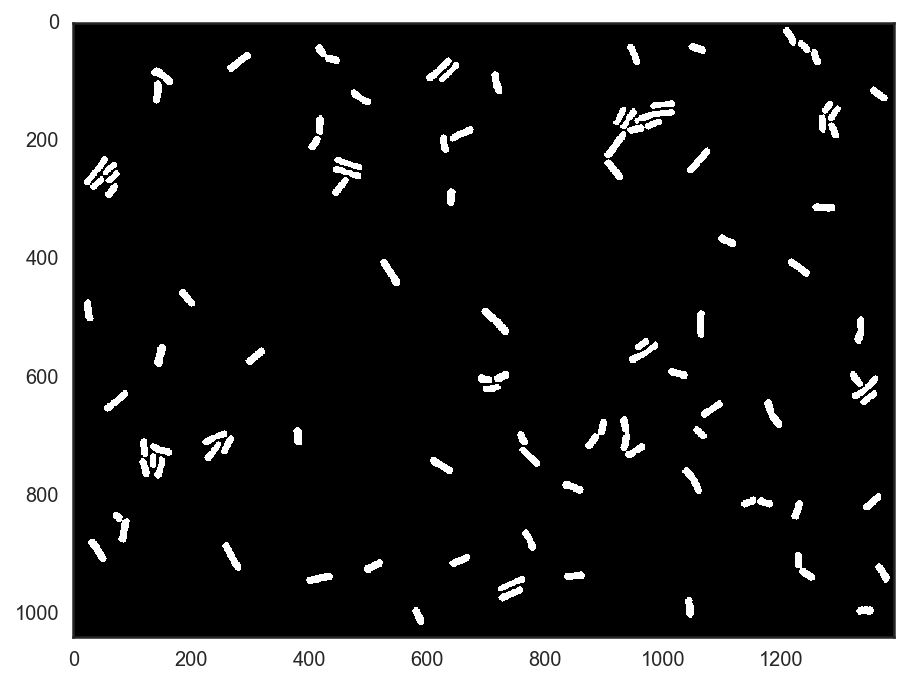

In [29]:
# Clear border with large buffer size b/c LoG procedure came off border
im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

## Labeling binary images

We have now separated out our bacteria.  We would like to label all individual bacteria so we can keep track of who's who.  The `skimage.measure.label` function conveniently does this.  It returns an "image" where the pixel values are the number that labels the connected regions.  The background is labeled with `-1`, and all other regions are labeled with integers starting at 1.  **WARNING:** In the forthcoming v0.12 of `scikit-image`, the background will be labeled with `0`.

Number of individual bacteria =  92


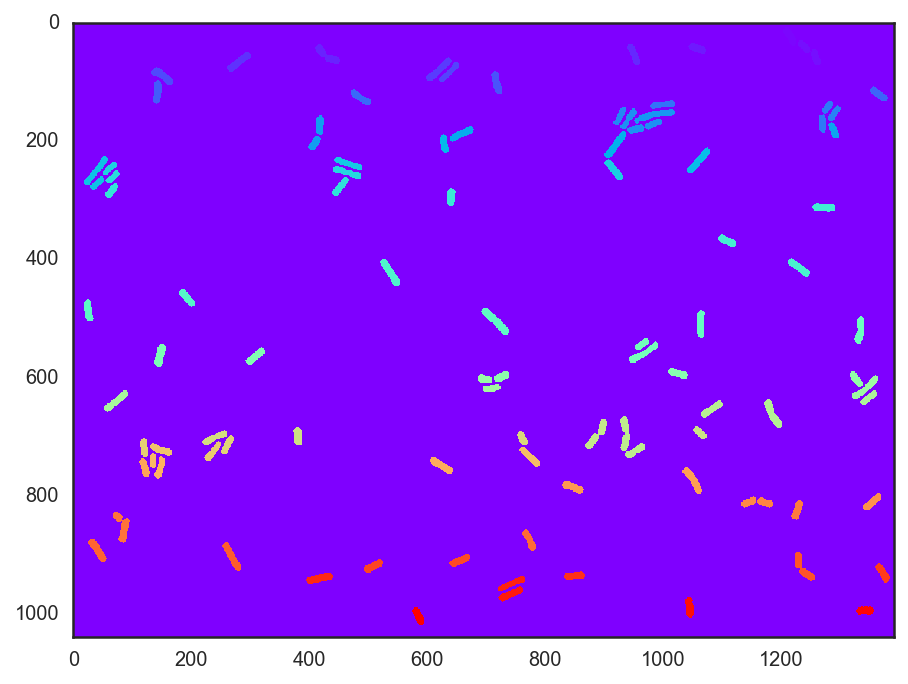

In [33]:
# Label binary image; backward kwarg says value in im_bw to consider backgr.
im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)

# See result (one of the few times it's ok to use rainbow colormap!)
with sns.axes_style('white'):
    plt.imshow(im_labeled, cmap=plt.cm.rainbow)

# Show number of bacteria
print('Number of individual bacteria = ', n_labels - 1)

## Computing region properties

This labeled image can now be used to identify bacteria in the other channels.  The only problem is that this image is not binned, while the others are.  We can losslessly upsample the other images, making each four pixel block the same value as the original pixel.  This does not add or lose any information.  We can do this using the `scipy.ndimage.zoom()` function.  Let's do that for the other channels.

In [34]:
# Load other images
image_dir = '../data/park_et_al/'
im_p_file = image_dir + 'snaps001-001-p.tif'
im_c_file = image_dir + 'snaps001-001-c.tif'
im_y_file = image_dir + 'snaps001-001-y.tif'

# Load images and store in list [phase, RFP, CFP, YFP]
im_p = skimage.io.imread(im_p_file)
im_c = skimage.io.imread(im_c_file)
im_y = skimage.io.imread(im_y_file)

# Upsample other images (2 means 2x as big, order=0 means no interpolation)
im_p = scipy.ndimage.zoom(im_p, 2, order=0)
im_c = scipy.ndimage.zoom(im_c, 2, order=0)
im_y = scipy.ndimage.zoom(im_y, 2, order=0)

Now that the images are resampled, we can compute properties about them using the labeled image.  This is done very conveniently using the `skimage.measure.regionprops` function.  It computes things about the labeles image, such as area, perimeter, etc., for each labeled region.  If we pass a kwarg `intensity_image`, it uses the labels in the labeled image and computes properties of the intensity image, in our case the CFP and YFP channels.  The result is returnd as a list of `regionprops` objects.

In [35]:
# Get properties about the CFP and YFP channels
im_c_props = skimage.measure.regionprops(im_labeled, intensity_image=im_c)
im_y_props = skimage.measure.regionprops(im_labeled, intensity_image=im_y)

Let's look at the properties of the CFP channel.

In [36]:
# Loop through properties and print area and mean intensity in CFP channel
for prop in im_c_props:
    print("""
    bacterium {0:d}: area = {1:.1f} µm^2, mean intensity = {2:d} (a.u)
    """.format(prop.label, prop.area * physical_size**2, 
               int(prop.mean_intensity)))


    bacterium 1: area = 2.5 µm^2, mean intensity = 841 (a.u)
    

    bacterium 2: area = 1.5 µm^2, mean intensity = 541 (a.u)
    

    bacterium 3: area = 2.4 µm^2, mean intensity = 956 (a.u)
    

    bacterium 4: area = 1.7 µm^2, mean intensity = 796 (a.u)
    

    bacterium 5: area = 2.3 µm^2, mean intensity = 576 (a.u)
    

    bacterium 6: area = 2.5 µm^2, mean intensity = 627 (a.u)
    

    bacterium 7: area = 1.7 µm^2, mean intensity = 620 (a.u)
    

    bacterium 8: area = 2.2 µm^2, mean intensity = 749 (a.u)
    

    bacterium 9: area = 2.0 µm^2, mean intensity = 985 (a.u)
    

    bacterium 10: area = 1.9 µm^2, mean intensity = 784 (a.u)
    

    bacterium 11: area = 1.6 µm^2, mean intensity = 691 (a.u)
    

    bacterium 12: area = 1.8 µm^2, mean intensity = 838 (a.u)
    

    bacterium 13: area = 1.7 µm^2, mean intensity = 688 (a.u)
    

    bacterium 14: area = 2.4 µm^2, mean intensity = 938 (a.u)
    

    bacterium 15: area = 1.2 µm^2, mean intensity = 877 

As you might expect, it is much easier to look at regions props in a Pandas `DataFrame`.  A couple of your classmates have written a little utility to do that, available [here](https://github.com/chigozienri/regionprops_to_df).

Finally, let's plot the mean intensity in the CFP channel versus that in the YFP channel.

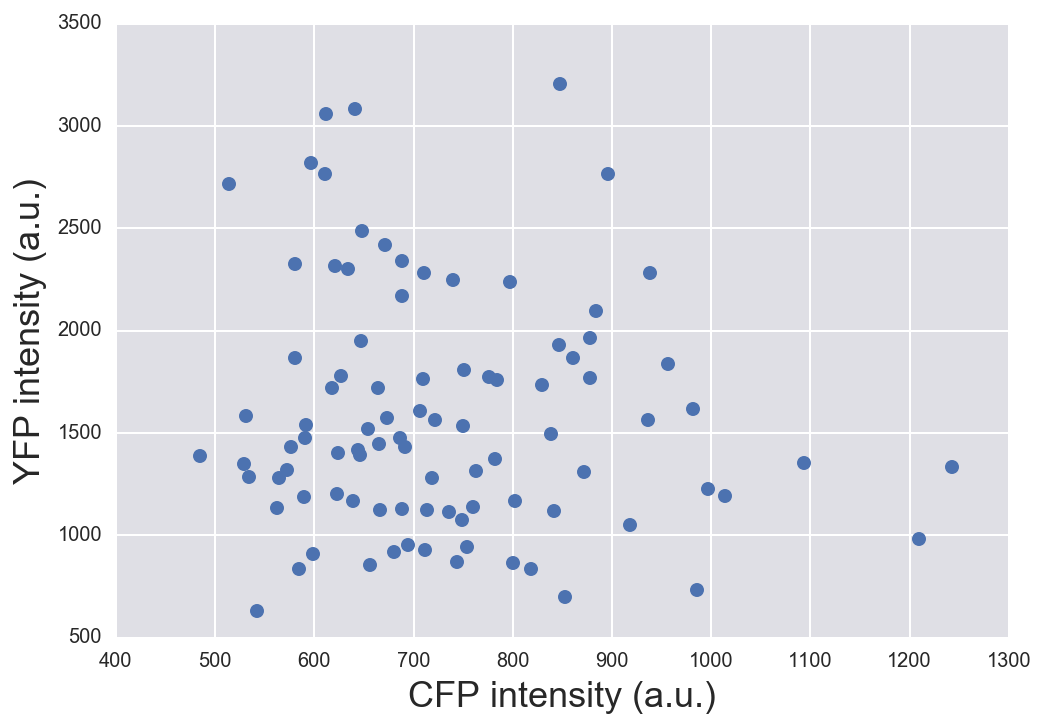

In [38]:
# Compute NumPy array of mean intensities
mean_c_intensity = np.empty(len(im_c_props))
mean_y_intensity = np.empty(len(im_y_props))
for i in range(len(im_c_props)):
    mean_c_intensity[i] = im_c_props[i].mean_intensity
    mean_y_intensity[i] = im_y_props[i].mean_intensity

# Plot intensities
plt.plot(mean_c_intensity, mean_y_intensity, 'o')
plt.xlabel('CFP intensity (a.u.)')
plt.ylabel('YFP intensity (a.u.)')

## Displaying segementation

We complete this tutorial by showing how we can display segmentation over an image.  We demonstrate this with the phase image and our segmented RFP image.  The strategy is similar to what we did the the ROIs.  We convert the gray scale image to RGB and then color one channel with the segmented image.

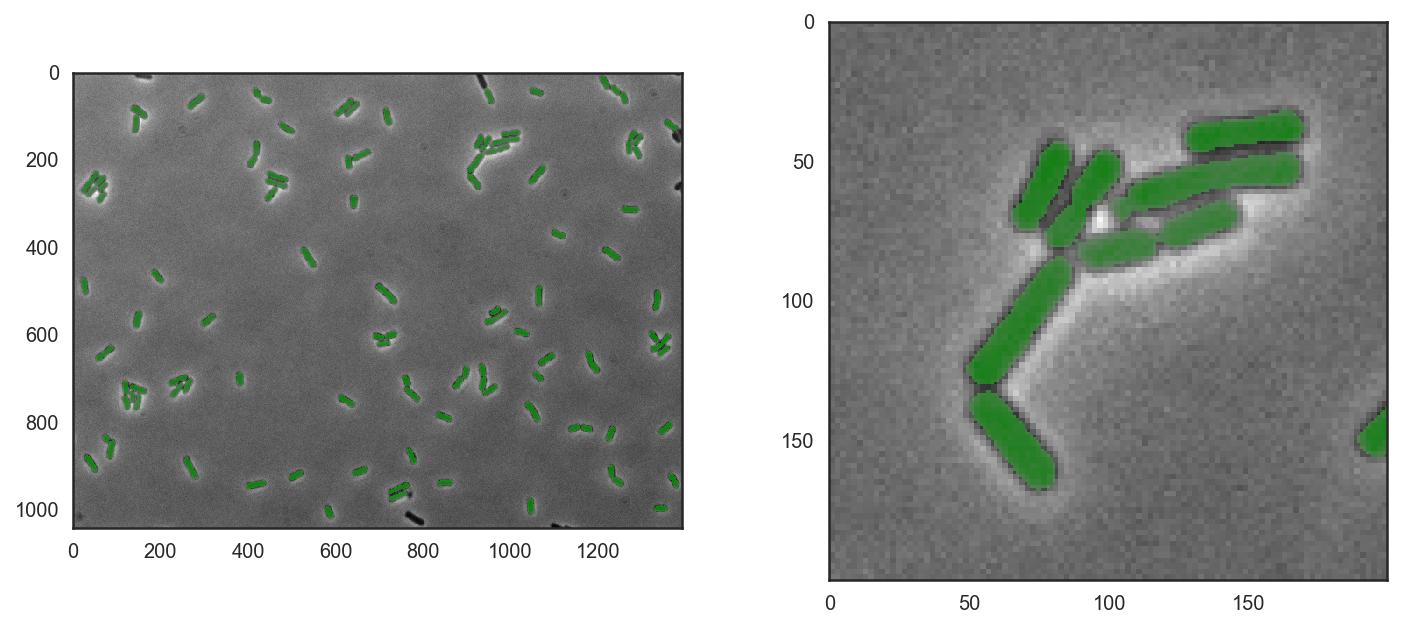

In [40]:
# Convert phase image to float RGB
im_p_float = (im_p - im_p.min()) / (im_p.max() - im_p.min())

# Make the green channel 1/2 wherever we have a bacterium
im_p_g = np.copy(im_p_float)
im_p_g[im_bw] = 0.5

# Build RGB image
im_p_rgb = np.dstack((im_p_float, im_p_g, im_p_float))

# Show result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].imshow(im_p_rgb)
    ax[1].imshow(im_p_rgb[100:300, 850:1050])